## 7.6. 残差网络（ResNet）
随着我们设计越来越深的网络，深刻理解“新添加的层如何提升神经网络的性能”变得至关重要。更重要的是设计网络的能力，在这种网络中，添加层会使网络更具表现力， 为了取得质的突破，我们需要一些数学基础知识。

### 7.6.1. 函数类
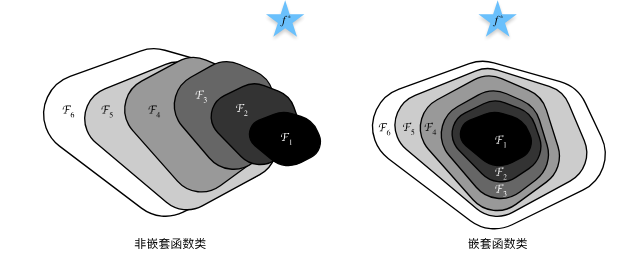  
只有当较复杂的函数类包含较小的函数类时，我们才能确保提高它们的性能。 对于深度神经网络，如果我们能将新添加的层训练成恒等映射（identity function）$f(\mathbf{x}) = \mathbf{x}$，新模型和原模型将同样有效。 同时，由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。  
**残差网络的核心思想**：每个附加层都应该更容易地包含原始函数作为其元素之一。

### 7.6.2 残差块
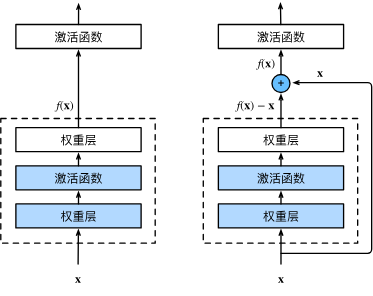  
假设我们的原始输入为$x$，而希望学出的理想映射为$f(\mathbf{x})$（作为 图7.6.2上方激活函数的输入）。 图7.6.2左图虚线框中的部分需要直接拟合出该映射$f(\mathbf{x})$，而右图虚线框中的部分则需要拟合出残差映射$f(\mathbf{x})-mathbf{x}$。 残差映射在现实中往往更容易优化。 以本节开头提到的恒等映射作为我们希望学出的理想映射$f(\mathbf{x})$，我们只需将 图7.6.2中右图虚线框内上方的加权运算（如仿射）的权重和偏置参数设成0，那么$f(\mathbf{x})$即为恒等映射。 实际中，当理想映射$f(\mathbf{x})$极接近于恒等映射时，残差映射也易于捕捉恒等映射的细微波动

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

c:\Users\yy200\miniconda3\envs\d2l\lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [4]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### 7.6.3. ResNet模型
ResNet18:  
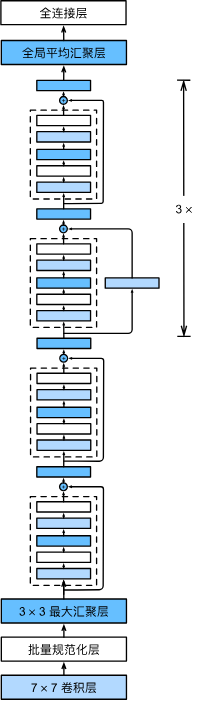

In [5]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [7]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [9]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


### 7.6.4 训练模型

loss 0.021, train acc 0.994, test acc 0.900
2608.4 examples/sec on cuda:0


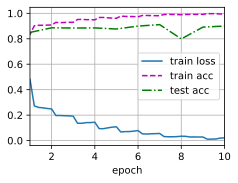

In [11]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

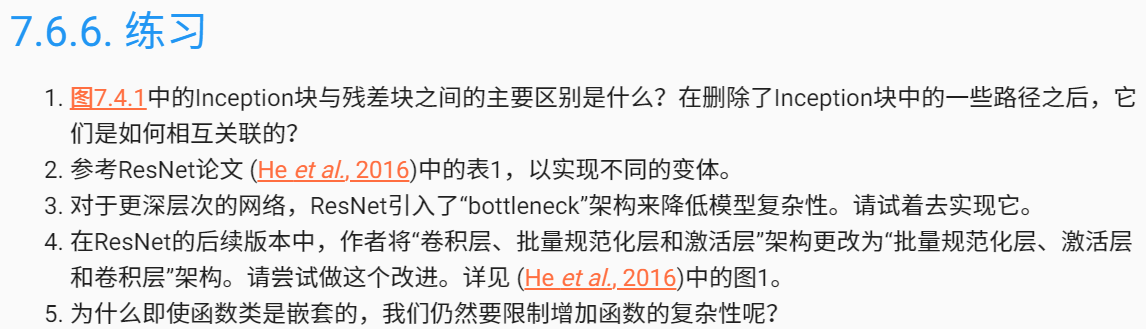

### 解答

#### 1. 图7.4.1中的Inception块与残差块之间的主要区别是什么？在删除了Inception块中的一些路径之后，它们是如何相互关联的？

Inception块和残差块的主要区别在于它们的设计目标和结构：
- **Inception块**：通过并行的多种卷积核和池化操作捕获不同尺度的特征，最终将这些特征拼接在一起。
- **残差块**：通过引入跳跃连接（skip connection）直接将输入加到输出上，主要用于缓解深度网络中的梯度消失问题。

当删除Inception块中的一些路径后，它可以被视为一种特殊的残差块，因为残差块也可以看作是Inception块的一种简化形式，其中只有一条主路径和一条跳跃连接路径。

#### 2. 参考ResNet论文（He et al., 2016）中的表1，实现不同的变体。

以下是ResNet论文中表1的变体实现代码：

```python
def resnet18():
    return nn.Sequential(
        b1,
        nn.Sequential(*resnet_block(64, 64, 2, first_block=True)),
        nn.Sequential(*resnet_block(64, 128, 2)),
        nn.Sequential(*resnet_block(128, 256, 2)),
        nn.Sequential(*resnet_block(256, 512, 2)),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(512, 10)
    )
```

#### 3. 对于更深层次的网络，ResNet引入了“bottleneck”架构来降低模型复杂性。请试着去实现它。

以下是“bottleneck”架构的实现代码：

```python
class Bottleneck(nn.Module):  # @save
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv3 = nn.Conv2d(num_channels, num_channels * 4, kernel_size=1)
        if use_1x1conv:
            self.conv4 = nn.Conv2d(input_channels, num_channels * 4, kernel_size=1, stride=strides)
        else:
            self.conv4 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.bn3 = nn.BatchNorm2d(num_channels * 4)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.conv4(X)
        Y += X
        return F.relu(Y)
```

#### 4. 在ResNet的后续版本中，作者将“卷积层、批量规范化层和激活层”架构更改为“批量规范化层、激活层和卷积层”架构。请尝试做这个改进。详见（He et al., 2016）中的图1。

以下是改进后的代码：

```python
class ResidualV2(nn.Module):  # @save
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

    def forward(self, X):
        Y = self.conv1(F.relu(self.bn1(X)))
        Y = self.conv2(F.relu(self.bn2(Y)))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return Y
```

#### 5. 为什么即使函数类是嵌套的，我们仍然要限制增加函数的复杂性呢？

即使函数类是嵌套的，限制增加函数复杂性仍然很重要，原因如下：
1. **过拟合风险**：过于复杂的函数可能会过拟合训练数据，导致模型在测试数据上的泛化能力下降。
2. **计算成本**：复杂的函数通常需要更多的计算资源，增加了训练和推理的时间成本。
3. **优化难度**：复杂的函数可能会导致优化问题变得更加困难，梯度下降可能会陷入局部最优或收敛缓慢。

因此，限制函数复杂性有助于提高模型的泛化能力、降低计算成本并简化优化过程。